# K-means

In [2]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from skimage.exposure import equalize_adapthist


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

import plotly.graph_objects as go

In [3]:
class ClusteredBands:
    
    def __init__(self, rasters_list):
        self.rasters = rasters_list
        self.model_input = None
        self.width = 0
        self.height = 0
        self.depth = 0
        self.no_of_ranges = None
        self.models = None
        self.predicted_rasters = None
        self.s_scores = []
        self.inertia_scores = []
    
    def set_raster_stack(self):
        l = []
        for i in self.rasters:
          with rio.open(i, 'r') as f:
            l.append(f.read(1))

        # Data
        arr_st = np.stack(l) 
        self.depth, self.height, self.width = arr_st.shape
        x = np.moveaxis(arr_st, 0, -1)
        #self.model_input = bands_stack.reshape(self.width * self.height, self.depth)
        self.model_input = x.reshape(-1, 12)
        print(self.model_input.shape)
    

    def build_models(self, no_of_clusters_range):
        self.no_of_ranges = no_of_clusters_range
        models = []
        predicted = []
        inertia_vals = []
        s_scores = []
        for n_clust in no_of_clusters_range:
            kmeans = KMeans(n_clusters=n_clust)
            y_pred = kmeans.fit_predict(self.model_input)
            
            # Append model
            models.append(kmeans)
            
            # Calculate metrics
            s_scores.append(self._calc_s_score(y_pred))
            inertia_vals.append(kmeans.inertia_)
            
            # Append output image (classified)
            quantized_raster = np.reshape(y_pred, (self.height, self.width))
            predicted.append(quantized_raster)
            
        self.models = models
        self.predicted_rasters = predicted
        self.s_scores = s_scores
        self.inertia_scores = inertia_vals

    def _calc_s_score(self, labels):
        s_score = silhouette_score(self.model_input, labels, sample_size=1000)
        return s_score

    def show_clustered(self):
        for idx, no_of_clust in enumerate(self.no_of_ranges):
            title = 'Number of clusters: ' + str(no_of_clust)
            image = self.predicted_rasters[idx]
            ep.plot_bands(image, cmap ='Accent',title = 'Number of clusters: ' + str(no_of_clust))
              #map=ListedColormap(['forestgreen', 'navy', 'black', 
              #                    'green', '#CA6F1E', 'darkgreen']))
            plt.show()

    def show_inertia(self):
        plt.figure(figsize = (10,10))
        plt.title('Inertia of the models')
        plt.plot(self.no_of_ranges, self.inertia_scores)
        plt.show()
        
    def show_silhouette_scores(self):
        plt.figure(figsize = (10,10))
        plt.title('Silhouette scores')
        plt.plot(self.no_of_ranges, self.s_scores)
        plt.show()
    
    def clustering(self,k):
        kmeans = KMeans(n_clusters=k)
        gt_kmeans = kmeans.fit_predict(self.model_input)
        gt_kmeans = gt_kmeans.reshape(self.height, self.width)
        return gt_kmeans, self.model_input

In [4]:
Aquileria_italy = glob("aquileria_italy/*B?*.tiff")
Aquileria_italy.sort()
clustered_models = ClusteredBands(Aquileria_italy)
clustered_models.set_raster_stack()
ranges = np.arange(5, 15, 1)
clustered_models.build_models(ranges)

(826800, 12)


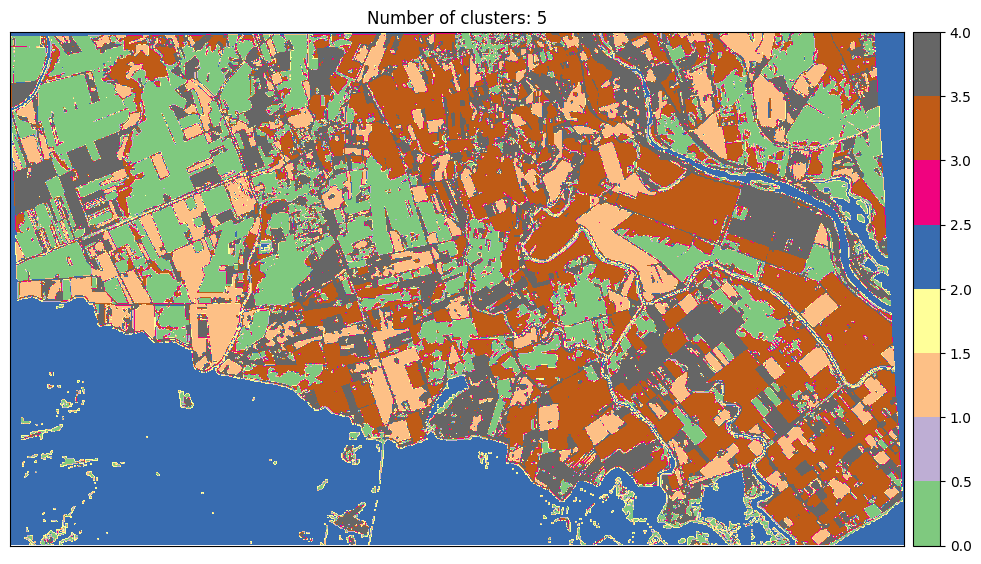

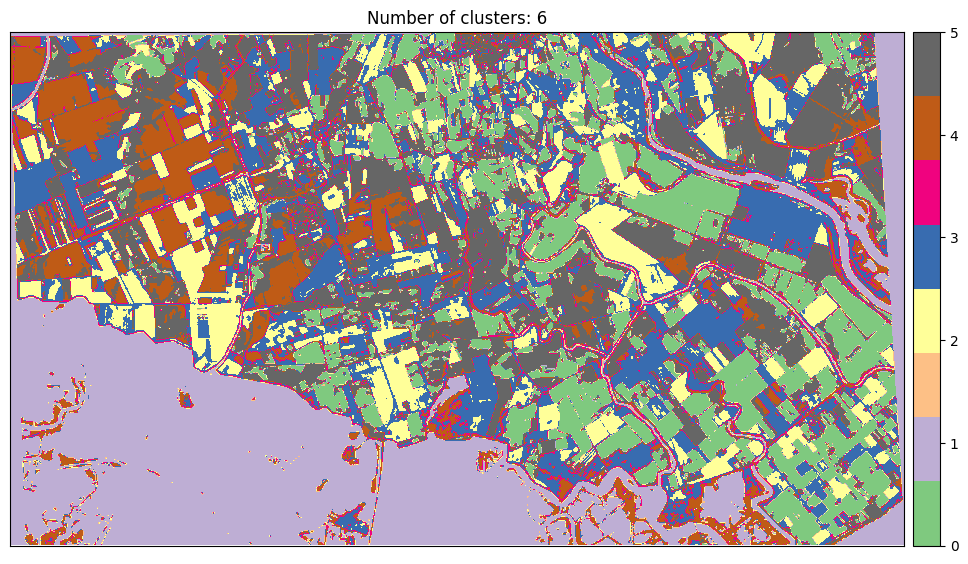

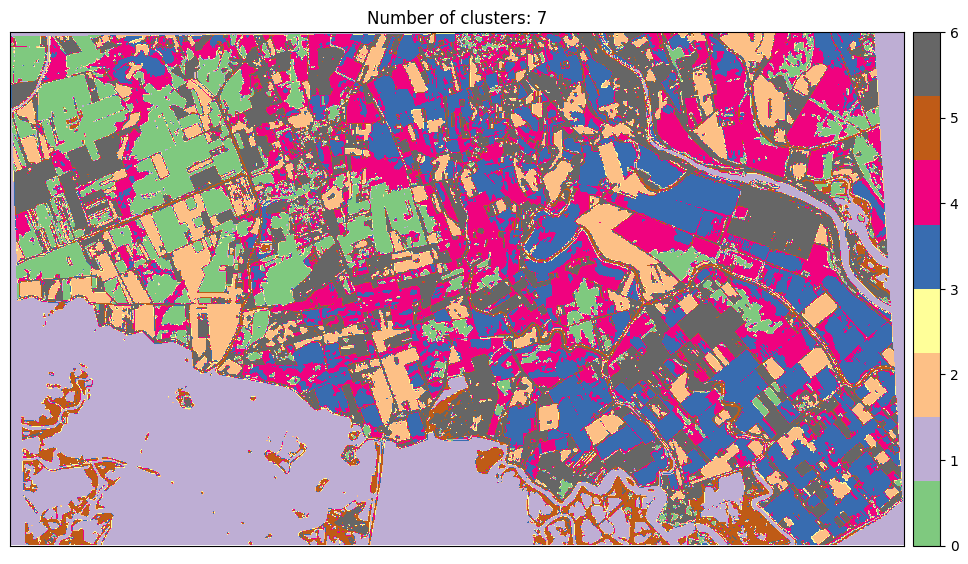

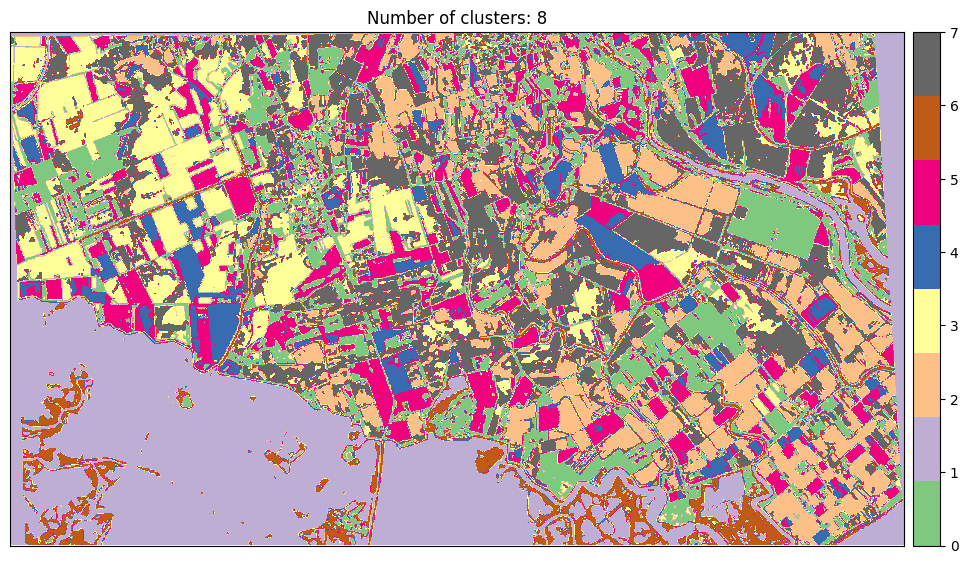

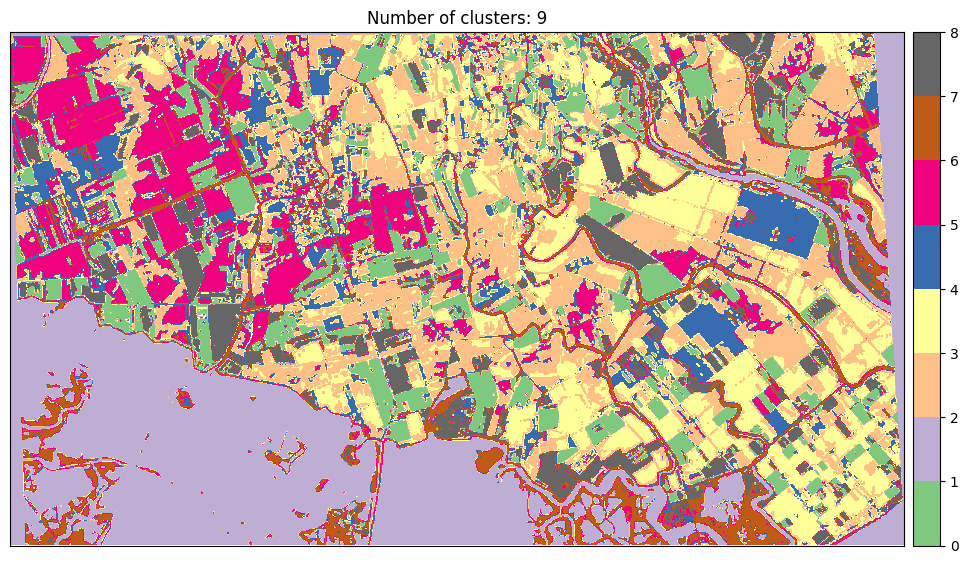

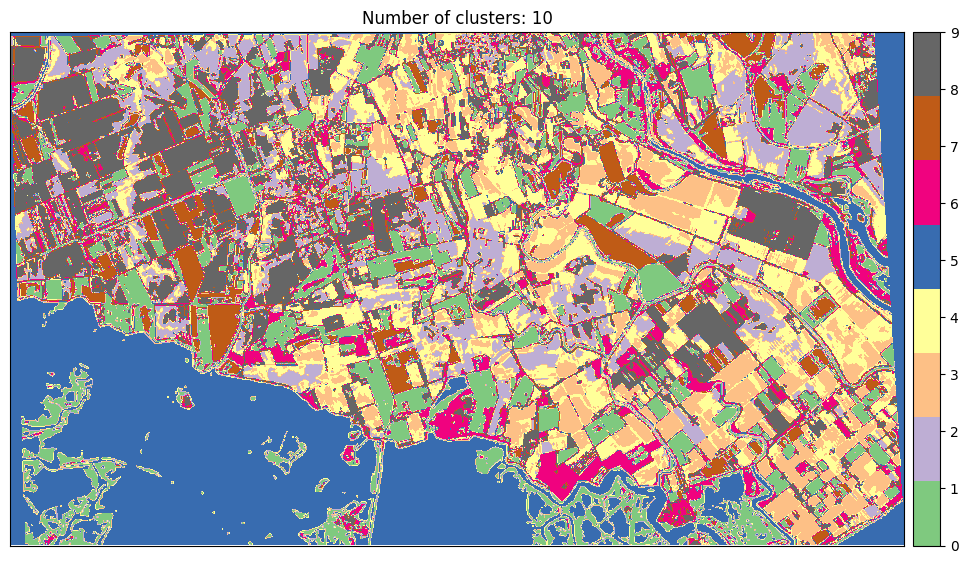

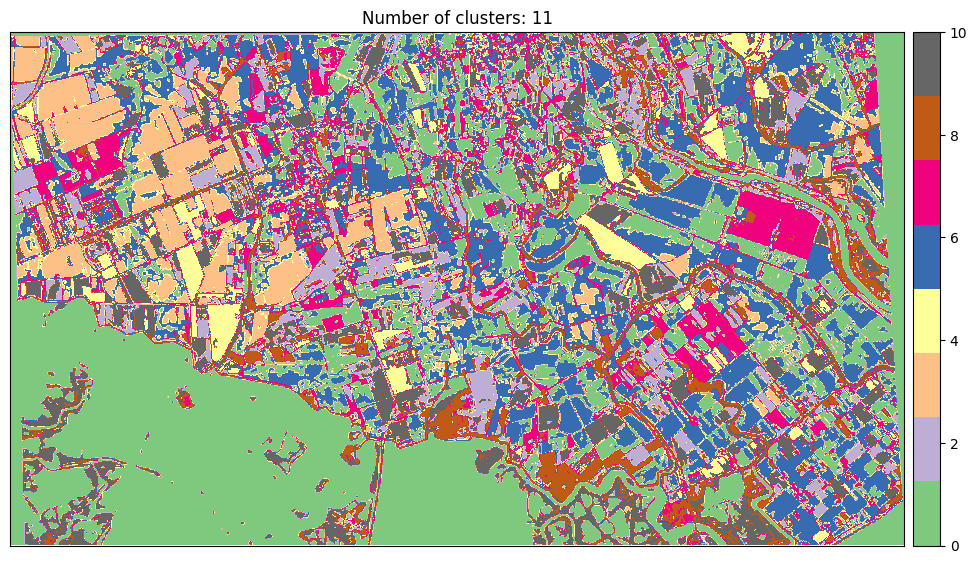

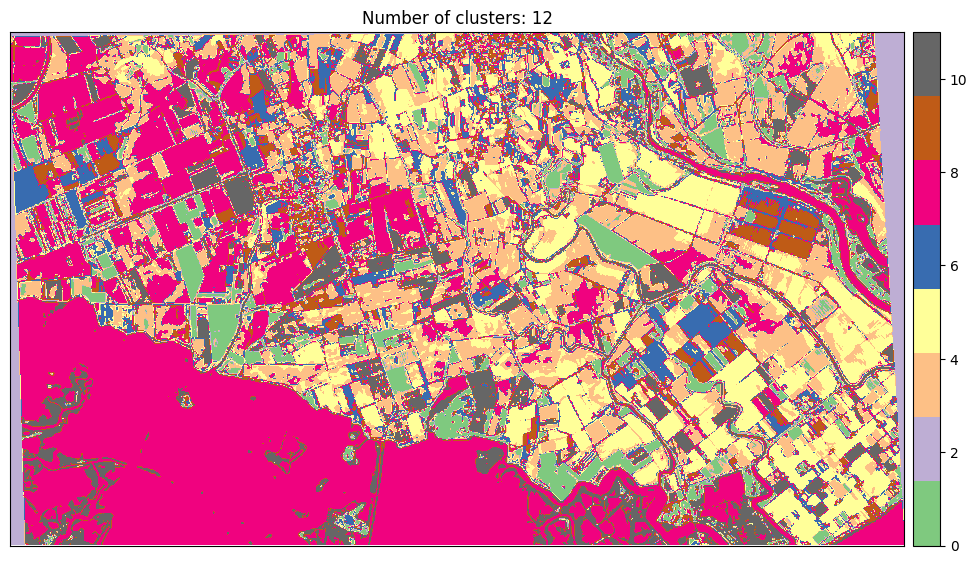

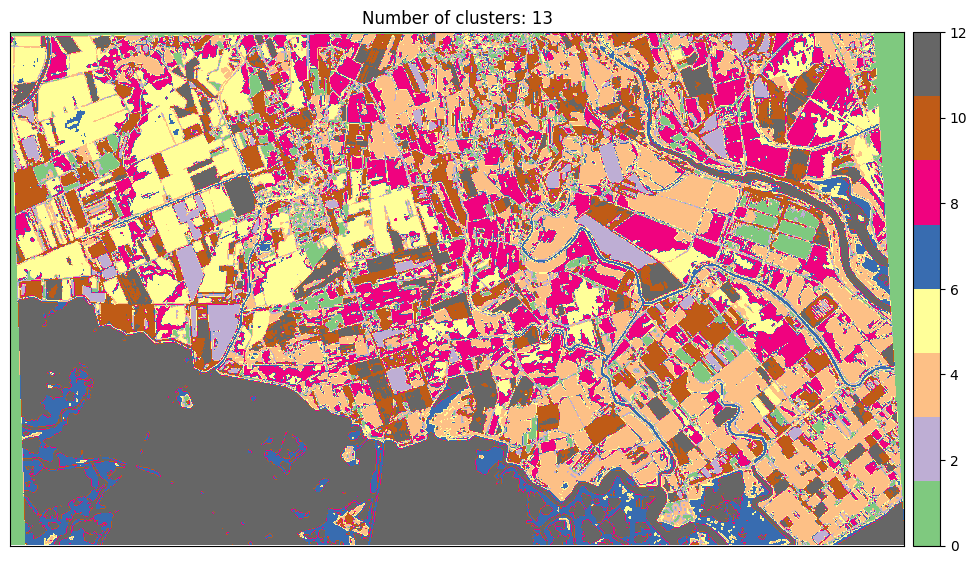

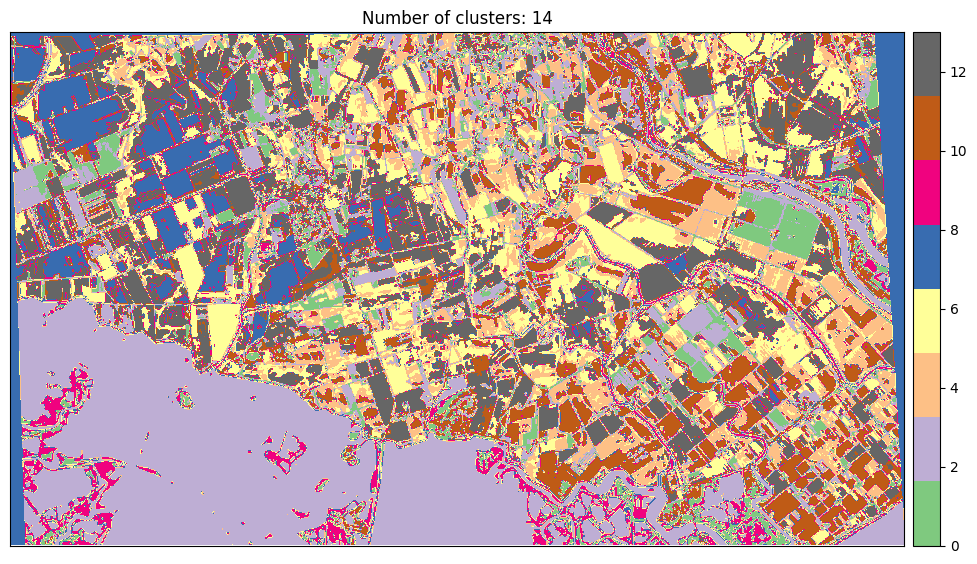

In [5]:
clustered_models.show_clustered()

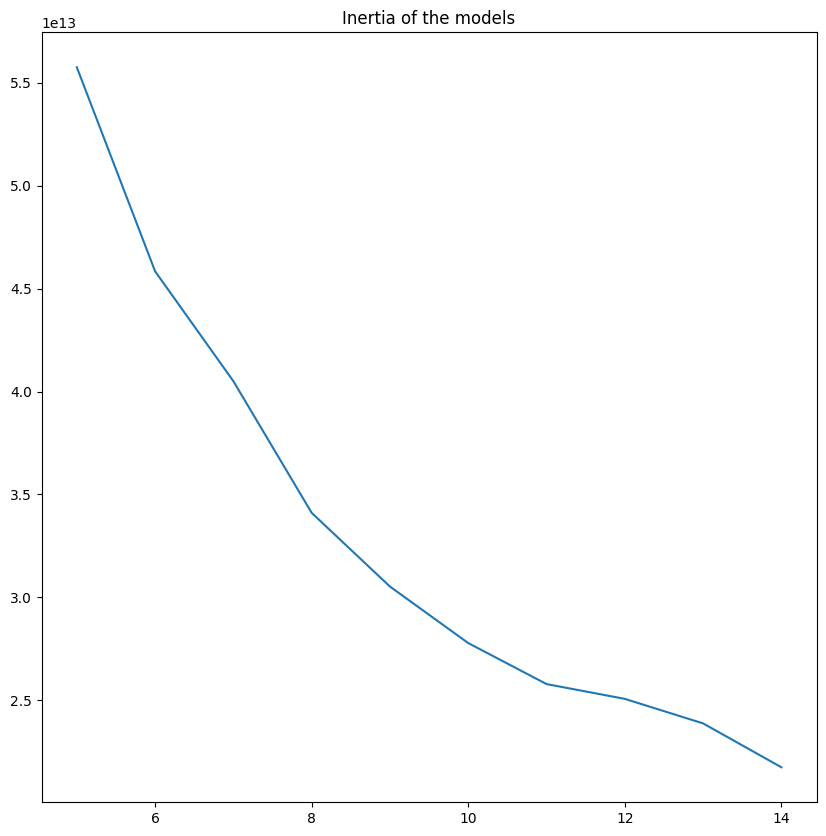

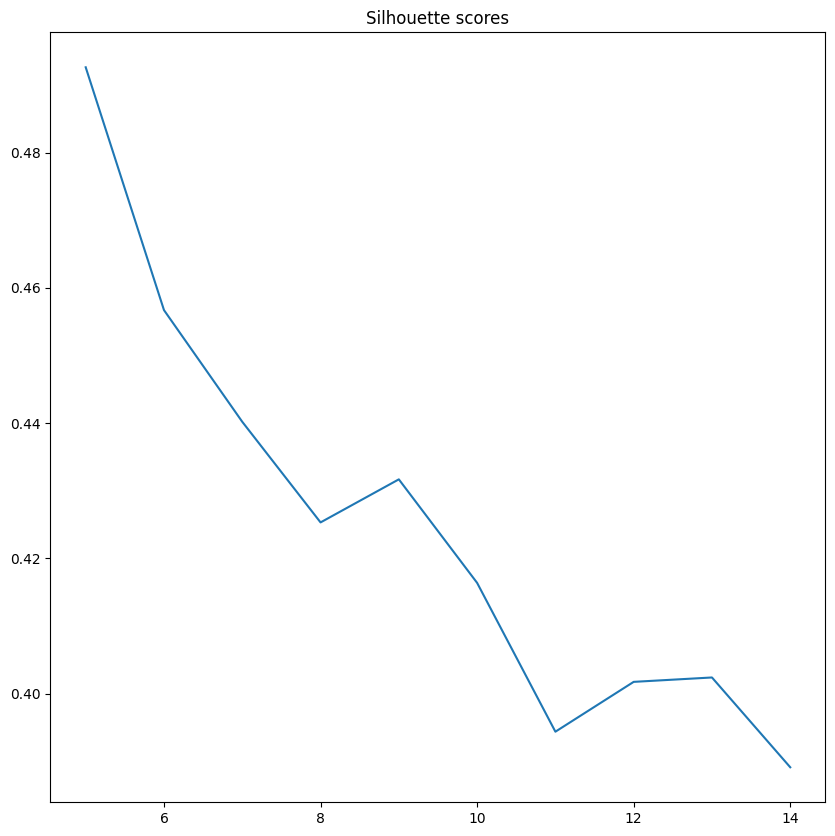

In [6]:
clustered_models.show_inertia()
clustered_models.show_silhouette_scores()

In [7]:
gt_kmeans, X_data = clustered_models.clustering(9)
gt_kmeans.shape

(689, 1200)

In [ ]:
np.savetxt('aquileria_GT.csv', gt_kmeans, delimiter=',')